In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%set_env PYTHONBREAKPOINT=IPython.core.debugger.set_trace

env: PYTHONBREAKPOINT=IPython.core.debugger.set_trace


In [2]:
from fastai.vision import *

In [3]:
vcand = np.load('vcand_case3.npy')
nview = 160

In [4]:
path = Path('./data_MIRO')
path.ls()

[PosixPath('data_MIRO/val'),
 PosixPath('data_MIRO/train'),
 PosixPath('data_MIRO/models')]

In [5]:
classes = sorted(os.listdir(path/'train'))
classes

['bus',
 'car',
 'cleanser',
 'clock',
 'cup',
 'headphones',
 'mouse',
 'scissors',
 'shoe',
 'stapler',
 'sunglasses',
 'tape_cutter']

In [6]:
# For the validation dataset, count the number of data points for each class.
# Used to calculate accuracy-per-class during validation.

def directory(path,extension):
    list_dir = []
    list_dir = os.listdir(path)
    count = 0
    for file in list_dir:
        if file.endswith(extension): # eg: '.txt'
            count += 1
    return count

folders = [f.path for f in os.scandir(path/'val') if f.is_dir()]
folders = sorted(folders)
validCount = []
for folds in folders:
    validCount = np.append(validCount, directory(folds, '.png')//nview)
validCount = validCount.astype(int)

In [7]:
tfms = get_transforms(do_flip=False, flip_vert=False, max_rotate=0.0,
                      max_lighting=0.0, max_zoom=1.05, max_warp=0.0)

In [8]:
src = (ImageList.from_folder(path)
      .split_by_folder(train='train', valid='val')
      .label_from_folder())
src

LabelLists;

Train: LabelList (17280 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bus,bus,bus,bus,bus
Path: data_MIRO;

Valid: LabelList (1920 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bus,bus,bus,bus,bus
Path: data_MIRO;

Test: None

In [9]:
data = (src.transform(tfms, size=128)
        .databunch(bs=480).normalize(imagenet_stats))

data.train_dl = data.train_dl.new(shuffle=False)
data.valid_dl = data.valid_dl.new(shuffle=False)

if data.train_dl.dl.batch_size % nview != 0:
    print ('Error: batch size must be a multiplication of the number of views,', nview)
    exit()
    
sorted_img = sorted(data.train_ds.x.items)
sorted_cats = sorted(data.train_ds.y.items)

In [10]:
# Random permutation for validation set. Probably not necessary, but just an experiment to see if it makes
# any difference during training/validation.

# sorted_vimg = sorted(data.valid_ds.x.items)
# sorted_vcats = sorted(data.valid_ds.y.items)

# val_nsamp = int( len(data.valid_ds) / nview )

# inds = np.zeros( ( nview, val_nsamp ) ).astype('int')
# inds[ 0 ] = np.random.permutation(range(val_nsamp)) * nview
# for i in range(1,nview):
#     inds[ i ] = inds[ 0 ] + i
# inds = inds.T.reshape( nview * val_nsamp )
# print(inds)

# IL  = ImageList([sorted_vimg[i] for i in inds], path=path)
# data.valid_ds.x = IL
# CL = CategoryList([sorted_vcats[i] for i in inds], classes=classes, path=path)
# data.valid_ds.y = CL

# Sort validation data for easier evaluation later
data.valid_ds.x = ImageList(sorted(data.valid_ds.x.items), path=path)
data.valid_ds.y = CategoryList(sorted(data.valid_ds.y.items), classes=classes, path=path)

In [11]:
# idx = random.randint(0, 50000)
# print(data.valid_ds[idx][1], idx)
# data.valid_ds.items[idx]

In [12]:
# idx = 8779
# print(data.train_ds[idx])
# data.train_ds[idx][0]

In [23]:
class GenerateTargetrN(LearnerCallback):

    "Creates the target labels for a rotationNet implementation."
    
    def __init__(self, learn:Learner):
        super().__init__(learn)
        self.target_var = torch.LongTensor( learn.data.train_dl.dl.batch_size * nview )
        self.output = torch.Tensor()
        self.viewOrd = {}
        
    def on_loss_begin(self, last_output, last_target, train, **kwargs:Any)->None:
        
        if not train:
            return {'last_output':last_output, 'last_target':last_target}

        nsamp = int( last_output.size(0) / nview )
        target_ = torch.LongTensor( last_target.size(0) * nview )

        self.output = last_output
        num_classes = int( self.output.size( 1 ) / nview ) - 1
        self.output = self.output.view( -1, num_classes + 1 )

        # compute scores and decide target labels
        output_ = torch.nn.functional.log_softmax( self.output, dim=1 ) #try sigmoid instead?

        #subtracts the last col from every other col, removes last col
        output_ = output_[ :, :-1 ] - torch.t( output_[ :, -1 ].repeat(1, output_.size(1)-1).view(output_.size(1)-1, -1) )
        output_ = output_.view( -1, nview * nview, num_classes )
        output_ = output_.data.cpu().numpy()

        '''Arrange output_as:
           [x,:,:] = all the view's activations for image[x//num views]
           [:,y,:] = view activations for class[y]
           [:,:,z] = sample set[z]'''
        output_ = output_.transpose( 1, 2, 0 )

        #default view variable is the incorrect view
        for j in range(target_.size(0)):
            target_[ j ] = num_classes

        # Initialize scores to 0
        scores = np.zeros( ( vcand.shape[ 0 ], num_classes, nsamp ) )

        #add up scores for each of the candidates for viewpoint variables
        for j in range(vcand.shape[0]):
            for k in range(vcand.shape[1]):
                scores[ j ] = scores[ j ] + output_[ vcand[ j ][ k ] * nview + k ]

        for n in range( nsamp ):
            #finds max score for column that corresponds to target label (for each class label and sample group)
            j_max = np.argmax( scores[ :, last_target[ n * nview ], n ] )
            
            if last_target[n*nview].item() in self.viewOrd:
                if self.viewOrd[last_target[n*nview].item()] != j_max:
                    self.viewOrd[last_target[n*nview].item()] = j_max
            else:
                self.viewOrd.update( { last_target[n*nview].item() : j_max } )
                
            # Assign target labels. Only 1 view per image gets set to class label.
            # Others remain default, which is the incorrect view
            for k in range(vcand.shape[1]):
                target_[ n * nview * nview + vcand[ j_max ][ k ] * nview + k ] = last_target[ n * nview ]

        target_ = target_.cuda()
        self.target_var = torch.autograd.Variable(target_)

        return {'last_output':self.output, 'last_target':self.target_var}

    def on_epoch_end(self, **kwargs):
        
        f = open("viewOrderDict.pkl","wb")
        pickle.dump(self.viewOrd,f)
        f.close()

In [24]:
class rNAccuracy(LearnerCallback):
    _order=-20
    
    "Metrics for rotationNet implementation."
    

    def __init__(self, learn):
        super().__init__(learn)
  
    def on_train_begin(self, **kwargs):
        self.learn.recorder.add_metric_names(['rN_t_loss', 'Prec@1', 'Prec@5'])
        self.vcount_tot = 0
        self.prec1, self.prec5 = 0., 0.
        
    def on_epoch_begin(self, **kwargs):
        self.tloss_tot, self.vloss_tot, self.tcount, self.vcount= 0., 0., 0, 0
        self.incTargs = []
        
        #print weights to confirm body is frozen or not
#         print(list(learn.model.parameters())[0][0][0][1])
        
        # random permutation
        train_nsamp = int( len(learn.data.train_ds) / nview )
        
        inds = np.zeros( ( nview, train_nsamp ) ).astype('int')
        inds[ 0 ] = np.random.permutation(range(train_nsamp)) * nview
        for i in range(1,nview):
            inds[ i ] = inds[ 0 ] + i
        inds = inds.T.reshape( nview * train_nsamp )
        
        IL  = ImageList([sorted_img[i] for i in inds], path=path)
        learn.data.train_ds.x = IL
        CL = CategoryList([sorted_cats[i] for i in inds], classes=classes, path=path)
        learn.data.train_ds.y = CL
        
        # Print a random data item to check if they got shuffled correctly
#         idx = random.randint(0,len(learn.data.train_ds))
#         print(data.train_ds[idx][1], data.train_ds.items[idx])


    def on_batch_end(self, last_loss, last_output, last_target, train, **kwargs):
        
        if train:
            self.tloss_tot += last_loss
            self.tcount += 1
        else:
            self.vloss_tot += last_loss
            self.vcount += 1
            
            # Calculate accuracy
            
            output_ = last_output
            target = last_target
            target = target.cuda()
            target = target[0:-1:nview]
            nsamp = int( output_.size(0) / nview )
            batch_size = target.size(0)
            num_classes = int(output_.size( 1 )/ nview) - 1

            output_ = output_.view( -1, num_classes + 1 )
            output_ = torch.nn.functional.log_softmax( output_, dim=1 ) #try sigmoid instead?
            output_ = output_[ :, :-1 ] - torch.t( output_[ :, -1 ].repeat(1, output_.size(1)-1).view(output_.size(1)-1, -1) )
            output_ = output_.view( -1, nview * nview, num_classes )
            output_ = output_.data.cpu().numpy()
            output_ = output_.transpose( 1, 2, 0 )
            
            scores = np.zeros( ( vcand.shape[ 0 ], num_classes, batch_size ) )
            output = torch.zeros( ( batch_size, num_classes ) )

    
            for j in range(vcand.shape[0]):
                for k in range(vcand.shape[1]):
                    scores[ j ] = scores[ j ] + output_[ vcand[ j ][ k ] * nview + k ]

            for n in range( batch_size ):
                # For a given batch, n, np.argmax( scores[ :, :, n ] ) / scores.shape[ 1 ]
                # gets the index for the view that has the highest score, regardless of class.
                j_max = int( np.argmax( scores[ :, :, n ] ) / scores.shape[ 1 ] )
                # Scores[ j_max, :, n ] -- for batch n, view with highest score regardless of class.
                output[ n ] = torch.FloatTensor( scores[ j_max, :, n ] )

            # output[x,:] - view that had the highest class score for sample[x]
            # output[:,y] - score for class[y]
            output = output.cuda()


            topk = (1,5)
            maxk = max(topk)
            _, pred = output.topk(maxk, 1, True, True)
            pred = pred.t()

            correct = pred.eq(target.contiguous().view(1, -1).expand_as(pred))

            prec = []
            for k in topk:
                correct_k = correct[:k].view(-1).float().sum(0)
                prec.append(correct_k.mul_(100.0 / batch_size))
                
            self.prec1 += prec[0]*(last_output.size(0)//nview)
            self.prec5 += prec[1]*(last_output.size(0)//nview)
            self.vcount_tot += (last_output.size(0)//nview)
            
            # Save off incorrect predictions for evaluation at epoch end.
            idx =  (correct[0] == 0).nonzero()
            self.incTargs = np.append(self.incTargs, target[idx.view(-1)].data.cpu().numpy())

            return {'last_output':output}


    def on_epoch_end(self, last_metrics, epoch, **kwargs):
        
#         global viewOrd
#         viewOrd = self.viewOrd.astype(int)
#         np.save('viewOrder_MIRO.npy', viewOrd)
        
#         print('\n*******EPOCH', epoch, '********\n')
#         print('Error rate by class:')
#         # Count classes that have been incorrectly classified
#         u, counts = np.unique(self.incTargs, return_counts=True)
#         v = [validCount[i] for i in u.astype(int)]
#         unique = [classes[i] for i in u.astype(int)]
#         corrects = ((counts/v * 100) + 0.5).astype(int) / 100.0
#         countDict = dict(zip(unique, corrects))
#         print(countDict, len(countDict))
        

#         print('vcount:', self.vcount)
        return add_metrics(last_metrics, [self.tloss_tot/self.tcount,
                                          self.prec1/self.vcount_tot, self.prec5/self.vcount_tot])

In [25]:
numClasses = (data.c+1)*nview
rotationNetHead = create_head(512, numClasses)

In [26]:
learn = cnn_learner(data, models.alexnet, metrics=None, pretrained=True,
                    custom_head = rotationNetHead, callback_fns=[GenerateTargetrN, rNAccuracy])

In [27]:
learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,rN_t_loss,Prec@1,Prec@5,time
0,2.946178,7.770116,2.968603,16.666668,91.666672,00:30
1,1.945651,10.738402,1.637816,41.666668,87.500000,00:31
2,0.854177,16.891047,0.072664,50.000000,91.666664,00:31
3,0.423147,14.586866,0.066733,50.000000,93.750000,00:30
4,0.225702,12.778373,0.051679,56.666668,95.000008,00:30
5,0.131820,12.792022,0.046397,62.500000,95.833336,00:29
6,0.084669,13.166686,0.041231,66.666664,96.428574,00:29
7,0.060430,13.700248,0.037958,70.833336,96.875000,00:31
8,0.047647,14.078436,0.035670,74.074074,97.222221,00:30
9,0.040074,14.511142,0.033063,76.666672,97.500008,00:31


In [28]:
learn.save('stage_1_MIRO')

In [ ]:
learn.load('stage_1_MIRO');

In [29]:
learn.unfreeze()

In [30]:
learn.fit_one_cycle(25, slice(1e-6, 1e-2))

epoch,train_loss,valid_loss,rN_t_loss,Prec@1,Prec@5,time
0,0.023166,16.151909,0.023074,100.000000,100.000000,00:34
1,0.023134,16.531897,0.022932,100.000000,100.000000,00:33
2,0.023112,16.794004,0.022905,100.000000,100.000000,00:32
3,0.023280,17.530674,0.023201,100.000000,100.000000,00:32
4,0.023935,17.536877,0.024337,100.000008,100.000008,00:33
5,0.024534,19.588085,0.024859,100.000000,100.000000,00:32
6,0.024712,18.545589,0.024883,100.000000,100.000000,00:33
7,0.023550,18.693316,0.022476,100.000000,100.000000,00:32
8,0.022719,19.082691,0.021909,100.000000,100.000000,00:32
9,0.021202,19.775595,0.019706,100.000008,100.000008,00:33


In [31]:
learn.save('stage_2_MIRO')

In [ ]:
learn.load('stage_2_MIRO');

## Predict class and pose

In [98]:
# Load saved pickle file of the "best view order" determined during training.

viewOrd = pickle.load(open("viewOrderDict.pkl", "rb"))
viewOrd

{11: 10,
 9: 3,
 6: 2,
 4: 7,
 5: 2,
 1: 10,
 0: 10,
 10: 2,
 7: 14,
 2: 10,
 8: 10,
 3: 14}

In [240]:
# Load one image for prediction

# img = open_image('data/shoe2.jpg')
# batch = learn.data.one_item(img)
# xb, yb = batch
# xb = [xb]
# img

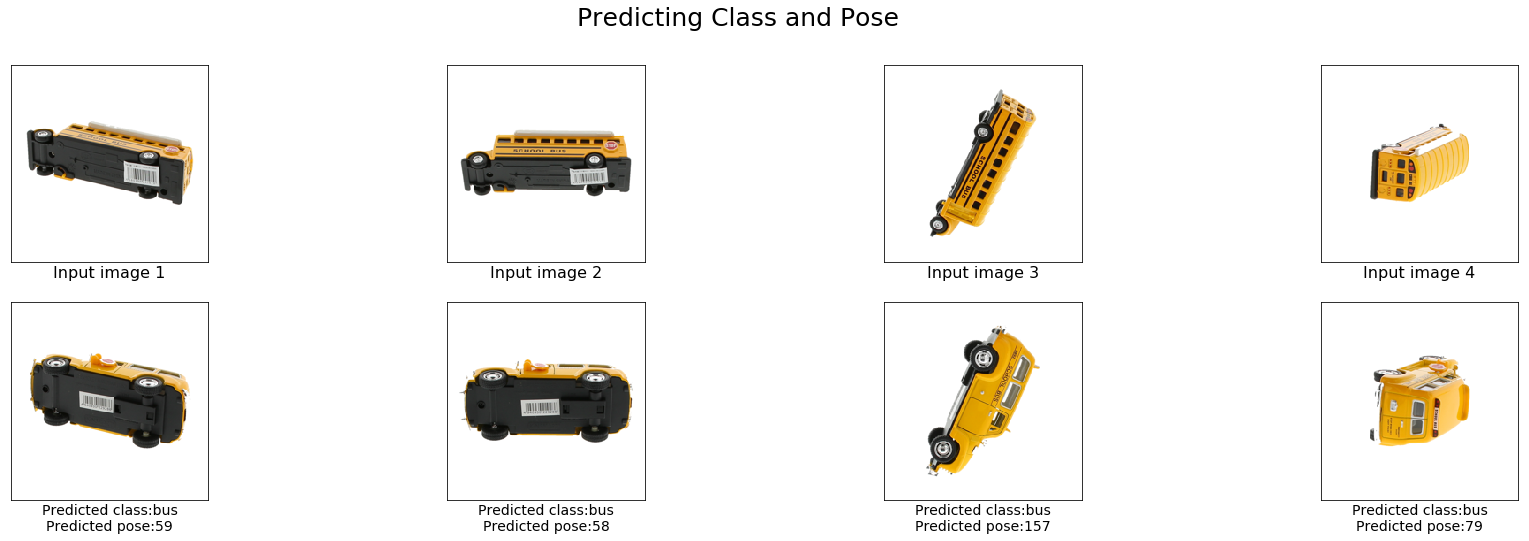

************************************************************
PREDICTED CLASS: bus -- predicted from 4 views
************************************************************


In [316]:
# Grab a randomly-sized group of views of a single object for inference
startGroup = 0
group = startGroup*nview
xb = torch.cuda.FloatTensor()
randnum = random.randint(1,20)
samp = iter(random.sample(range(nview), randnum))

fig=plt.figure(figsize=(30, 8))
columns = min(randnum, 10)
rows = 2
j = 1

for i in range(randnum):
    imgIdx = next(samp)
#     print(data.valid_ds.x.items[group+imgIdx], imgIdx, i)
    img = open_image(data.valid_ds.x.items[group+imgIdx])
    batch = learn.data.one_item(img)
    b,_ = batch
    xb = torch.cat((xb, b), dim=0)
    
    if i<10:
        img = PIL.Image.open(data.valid_ds.x.items[group+imgIdx])
        fig.add_subplot(rows, columns, j)
        plt.xlabel('Input image '+str(i+1), fontsize=16)
        plt.tick_params(axis='both', left=False, bottom=False, labelbottom=False, labelleft=False)
        fig.suptitle('Predicting Class and Pose', fontsize=25)
        j += 1
        plt.imshow(img)
        


xb = [xb]
learn.model.eval()
out = learn.model(*xb)
batch_size = xb[0].size(0)
num_classes = int(out.size( 1 )/ nview) - 1
out = out.view( -1, num_classes + 1 )
out = torch.nn.functional.log_softmax( out, dim=1 )
out = out[ :, :-1 ] - torch.t( out[ :, -1 ].repeat(1, out.size(1)-1).view(out.size(1)-1, -1) )
predictions = []
posePreds = []
for i in range(batch_size): 
    maxVals, idxs = torch.max(out[i*nview:i*nview+nview], dim=1)
    predictions.append(idxs[torch.argmax(maxVals)].item())
    posePreds.append(torch.argmax(maxVals).item())
#     print('prediction:', classes[idxs[torch.argmax(maxVals)].item()], '-- pose:', torch.argmax(maxVals).item())
values, counts = np.unique(predictions, return_counts=True)


j = columns+1
for i in range(10):
    pose = vcand[viewOrd[predictions[i]]][posePreds[i]]
    img = PIL.Image.open(sorted_img[predictions[i]*nview*9+nview*2+pose])
    fig.add_subplot(rows, columns, j)
#     plt.ylabel('Predicted pose:'+str(posePreds[i]), fontsize=16)
    plt.xlabel('Predicted class:'+classes[predictions[i]]+'\nPredicted pose:'+str(posePreds[i]), fontsize=14)
    plt.tick_params(axis='both', left=False, bottom=False, labelbottom=False, labelleft=False)
    j += 1
    plt.imshow(img)
    if i == batch_size-1:
        break

plt.show()
# plt.tight_layout()

print('*'*60)
print('PREDICTED CLASS:', classes[values[np.argmax(counts)]], '-- predicted from', batch_size, 'views')
if batch_size > 10:
    print('Showing first 10 views only')
print('*'*60)
